In [10]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch.utils.data import Dataset, DataLoader

In [2]:
def split(X, y, seed, z=None, train_size=0.7, test_size=0.3, val_size=0.2):
    X_val = None
    y_val = None
    Z_train, Z_val, Z_test = None, None, None
    if train_size is None and test_size is None:
        raise AttributeError()
    elif train_size is None:
        train_size = 1. - test_size
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, shuffle=True,
                                                        train_size=train_size)
    if z is not None:
        Z_train, Z_test = train_test_split(z, stratify=y, random_state=seed, shuffle=True, train_size=train_size)
    if val_size is not None:
        if z is not None:
            Z_train, Z_val = train_test_split(Z_train, stratify=y_train, random_state=seed, shuffle=True,
                                              test_size=val_size)

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=seed,
                                                          shuffle=True, test_size=val_size)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (Z_train, Z_val, Z_test)



In [3]:
def get_dataset(
        df: str | pd.DataFrame = 'dataset/EDOS_1M_balanced.pkl',
        seed=0
):
    df = df
    if isinstance(df, str):
        if df.endswith('pkl'):
            df = pd.read_pickle(df)
        else:
            df = pd.read_csv(df)
    groups = []
    labels = []
    confidence = []
    for name, group in df.groupby(by='eb+_emot'):
        group = group.reset_index(drop=True)
        groups.append(group.loc[:, 'uttr'])
        confidence.append(group.loc[:, 'label_confidence'])
        labels.append(group.loc[:, 'eb+_emot'])

    groups = np.array(groups, dtype=str)
    labels = np.array(labels, dtype=str)

    confidence = np.array(confidence, dtype=np.float32)
    return groups, labels, confidence


In [4]:
groups, labels, confidence = get_dataset()

In [6]:
unique = np.unique(labels.flatten())
emotions_to_category = {key: value for key, value in zip(unique, range(len(unique)))}
category_to_emotion = {key: value for key, value in zip(range(len(unique)), unique)}

seed = 0
(X_train, y_train), (X_val, y_val), (X_test, y_test), (Z_train, Z_val, Z_test) = split(groups.flatten(),
                                                                                       labels.flatten(), seed,
                                                                                       confidence.flatten())


In [7]:
X_train

array(["Tom 's okay . I guess he 's a little stuffy , but I think it 's from living with Paul so long .",
       'Joy .',
       "Baby 's sleeping . Oh , bless her little heart . Let 's go .",
       ..., 'Cleaning . Cooking a little bit .',
       'I would be honored . I pledge allegiance to the flag of the United States of America and to the republic for which it stands , one nation , under God , individis ... in the windowsill ... with liberty and justice for all .',
       "Don 't worry . I think it will be solved ."], dtype='<U532')

In [8]:
y_train

array(['content', 'joyful', 'grateful', ..., 'prepared', 'faithful',
       'encouraging'], dtype='<U13')

In [9]:
df_train = pd.DataFrame({'X_train': X_train, 'y_train': y_train})
df_train.head(5)

,X_train,y_train
0,"Tom 's okay . I guess he 's a little stuffy , ...",content
1,Joy .,joyful
2,"Baby 's sleeping . Oh , bless her little heart...",grateful
3,Can we leave the lit lights ?,suggesting
4,"Sajani , you have truly taken such good care o...",grateful


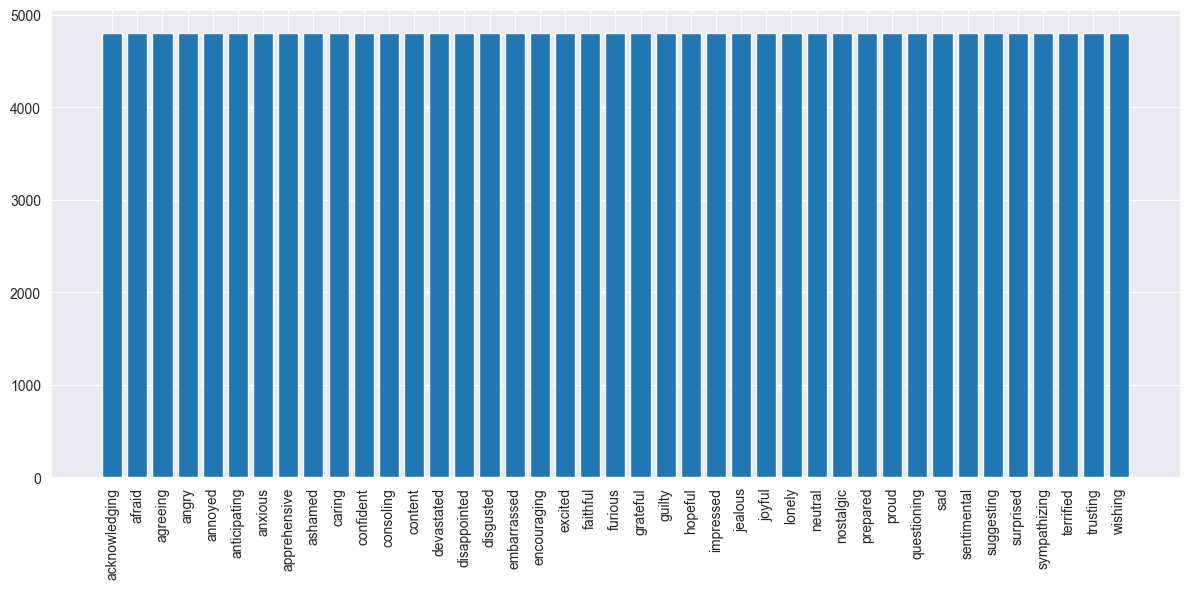

In [15]:
fig = plt.figure(figsize=(12,6))
emotion_list, emotion_count = np.unique(y_train, return_counts=True)
plt.bar(emotion_list, emotion_count)
plt.xticks(np.arange(0, len(emotion_list)), emotion_list, rotation=90)
plt.tight_layout()
plt.show()

In [50]:
# ZERO SHOT
from transformers import pipeline
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
pipe = pipeline('zero-shot-classification', model='cross-encoder/nli-distilroberta-base', device=DEVICE, batch_size=64)


In [51]:
df_test = pd.DataFrame({'X_test': X_train, 'y_test': y_train})
df_test = df_test.groupby('y_test').head(100)
df_test.shape

(4100, 2)

In [61]:
X_test_to_feed = df_test.loc[:, 'X_test'].to_numpy().tolist()
true_labels = df_test.loc[:, 'y_test'].to_numpy().tolist()
true_labels

['content',
 'joyful',
 'grateful',
 'suggesting',
 'grateful',
 'surprised',
 'confident',
 'nostalgic',
 'terrified',
 'embarrassed',
 'sentimental',
 'apprehensive',
 'consoling',
 'sympathizing',
 'angry',
 'ashamed',
 'annoyed',
 'anticipating',
 'joyful',
 'questioning',
 'suggesting',
 'annoyed',
 'excited',
 'hopeful',
 'questioning',
 'confident',
 'content',
 'annoyed',
 'caring',
 'anticipating',
 'disappointed',
 'furious',
 'consoling',
 'apprehensive',
 'sentimental',
 'disgusted',
 'suggesting',
 'nostalgic',
 'hopeful',
 'lonely',
 'devastated',
 'angry',
 'content',
 'angry',
 'annoyed',
 'guilty',
 'consoling',
 'faithful',
 'guilty',
 'angry',
 'questioning',
 'joyful',
 'sad',
 'faithful',
 'lonely',
 'nostalgic',
 'embarrassed',
 'embarrassed',
 'sad',
 'suggesting',
 'jealous',
 'suggesting',
 'suggesting',
 'hopeful',
 'hopeful',
 'nostalgic',
 'furious',
 'neutral',
 'hopeful',
 'jealous',
 'excited',
 'consoling',
 'acknowledging',
 'angry',
 'lonely',
 'agreei

In [59]:
from tqdm.notebook import tqdm
print_seq = True
out_labels = []
top_5 = []
for i in tqdm(range(0, len(X_test_to_feed), 64)):
    if i > 10:
        print_seq = False
    to_feed = X_test_to_feed[i:i+64]
    s = pipe(to_feed, candidate_labels=emotion_list)
    t = true_labels[i:i+64]
    if print_seq:
        print(f'SEQUENCE {i}: ', s[0]['sequence'])
        print(f'TRUE LABEL:', t[0])
    for j in range(0, len(s)):
        labels = np.array(s[j]['labels'])
        probs = np.array(s[j]['scores'])
        index = np.argsort(probs)[-5:][::-1]
        out_labels.append(labels[probs.argmax()])
        top_5.append(t[j] in labels[index])
    # if print_seq:
    #     print(f'TOP 5: {labels[index]} with probs: {probs[index]}\n\n')

  0%|          | 0/65 [00:00<?, ?it/s]

SEQUENCE 0:  Tom 's okay . I guess he 's a little stuffy , but I think it 's from living with Paul so long .
TRUE LABEL: content


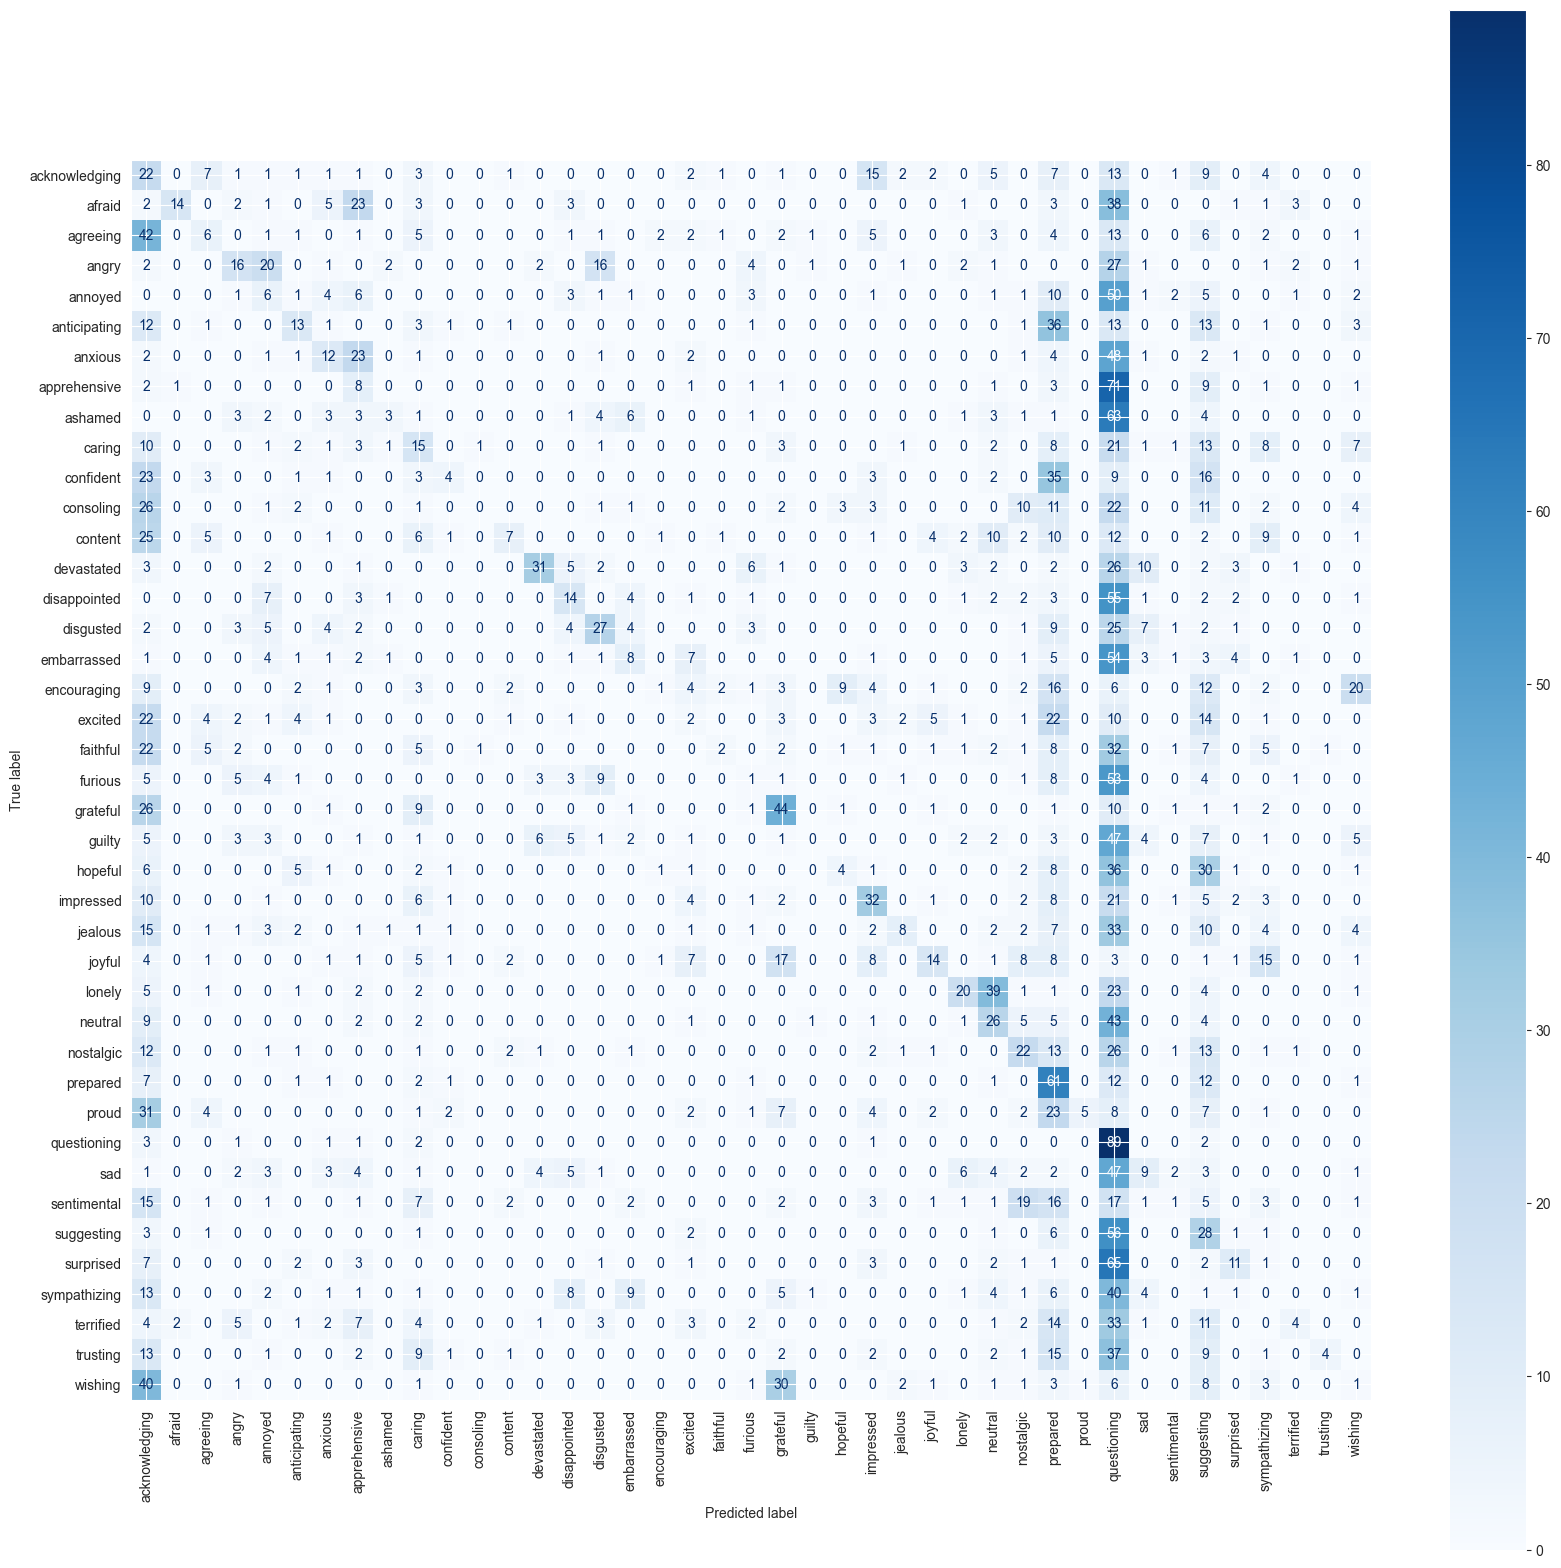

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

fig, ax = plt.subplots(figsize=(20, 20))
# cm = confusion_matrix(np.concatenate(real_labels, axis=0), np.concatenate(out_labels, axis=0))
disp = ConfusionMatrixDisplay.from_predictions(true_labels, out_labels,
                                               ax=ax,
                                               xticks_rotation='vertical',
                                               cmap=plt.cm.Blues)

In [63]:
print(classification_report(true_labels, out_labels))

               precision    recall  f1-score   support

acknowledging       0.05      0.22      0.08       100
       afraid       0.82      0.14      0.24       100
     agreeing       0.15      0.06      0.09       100
        angry       0.33      0.16      0.22       100
      annoyed       0.08      0.06      0.07       100
 anticipating       0.30      0.13      0.18       100
      anxious       0.25      0.12      0.16       100
 apprehensive       0.08      0.08      0.08       100
      ashamed       0.33      0.03      0.06       100
       caring       0.14      0.15      0.14       100
    confident       0.29      0.04      0.07       100
    consoling       0.00      0.00      0.00       100
      content       0.37      0.07      0.12       100
   devastated       0.65      0.31      0.42       100
 disappointed       0.26      0.14      0.18       100
    disgusted       0.39      0.27      0.32       100
  embarrassed       0.21      0.08      0.12       100
  encoura

In [66]:
top_5

[False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fals

In [67]:
print('TOP 5 SCORE:' ,np.mean(top_5))

TOP 5 SCORE: 0.4429268292682927


In [150]:

def row_to_text(row):
    return row['X_train'] + ' => ' + row['y_train']
df_train_copy = df_train.copy()
df_train_copy['X_train'] = df_train.apply(row_to_text, axis=1)
df_grouped = df_train_copy.groupby(by=['y_train'])
def insert_some_example(n_shot=len(emotion_list), g=12):
    global df_grouped, emotion_list
    repeat = n_shot // len(emotion_list)
    if repeat == 0:
        repeat = 1
    t = df_grouped.sample(n=repeat, replace=False, random_state=g).loc[:, 'X_train'].to_numpy(dtype=str)
    index = np.random.default_rng(g).choice(range(len(t)), replace=False, size=n_shot)
    t= t[index]
    return '\n'.join(t)


In [151]:
df_train = pd.DataFrame({'X_train': X_train, 'y_train': y_train})
# df_train.apply(lambda x: len(x) * y, axis=1)

In [ ]:
from tqdm.notebook import tqdm



def few_shot_learning(n_shot):
    print_seq = True
    out_labels = []
    top_5 = []
    with torch.no_grad():
        for i in tqdm(range(0, len(X_test_to_feed), 64)):
            if i > 10 * 64:
                print_seq = False
            to_feed = X_test_to_feed[i:i+64]
            for j in range(0, len(to_feed)):
                to_feed[j] = insert_some_example(n_shot, i+j) + '\n' + to_feed[j] + ' =>'
            s = pipe(to_feed, candidate_labels=emotion_list)
            t = true_labels[i:i+64]
            if print_seq:
                print(f'SEQUENCE {i}: ', s[0]['sequence'])
                print(f'TRUE LABEL:', t[0])
            for j in range(0, len(s)):
                labels = np.array(s[j]['labels'])
                probs = np.array(s[j]['scores'])
                index = np.argsort(probs)[-5:][::-1]
                out_labels.append(labels[probs.argmax()])
                top_5.append(t[j] in labels[index])
            if print_seq:
                print(f'TOP 5: {labels[index]} with probs: {probs[index]}\n\n')
    return out_labels , top_5      
out_labels , top_5  = few_shot_learning(5)

  0%|          | 0/65 [00:00<?, ?it/s]

SEQUENCE 0:  There is that certain section of the , er ... lesbian community that seem to enjoy it . You got to admire their fortitude , really , haven 't you ? Full fist . => impressed
Hold onto it well . => faithful
I was not made for this I don 't have the courage . You 'll find the courage in the doing of it Your Highness . => confident
You know Collins . He 's okay . Sure . => content
Then you always were so conscientious . Quite the model nurse , in fact ! => proud
Tom 's okay . I guess he 's a little stuffy , but I think it 's from living with Paul so long . =>
TRUE LABEL: content
TOP 5: ['terrified' 'afraid' 'embarrassed' 'apprehensive' 'anxious'] with probs: [0.10609668 0.09130296 0.07602135 0.07395973 0.05749202]

SEQUENCE 64:  It 's where someone hits their head and there 's cranial bleeding , but they behave fairly normally for a couple of hours . They have no idea of the amount of damage that 's been caused . So ... she met Lockford , called Croft . You said she sounded dr